In [1]:
from HRP import *
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

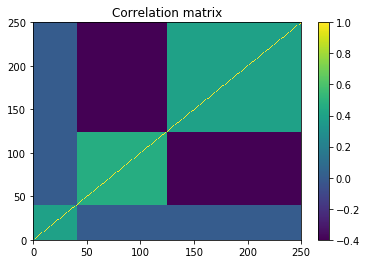

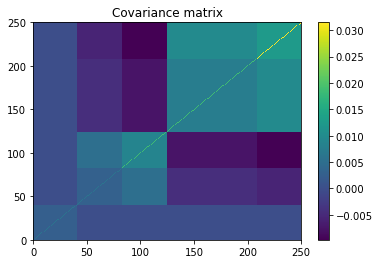

In [3]:
nb_alphas = 250
nb_observations = int(0.3 * 252)

# build a hierarchical block diagonal correlation matrix
quality = 0.6 * np.ones((nb_alphas // 6, nb_alphas // 6))
value = 2.4 * np.ones((nb_alphas // 2, nb_alphas // 2))
momentum = 2.6 * np.ones((int(nb_alphas * (1 - 1/6 - 1/2) + 1),
                          int(nb_alphas * (1 - 1/6 - 1/2) + 1)))

correl_mom_value = -1.2 * np.ones((int(nb_alphas * (1 - 1/6)) + 1,
                                   int(nb_alphas * (1 - 1/6)) + 1))


correl = (block_diag(quality, correl_mom_value) +
          block_diag(quality, momentum, value)) / 3
np.fill_diagonal(correl, 1)



mean_returns = np.zeros(nb_alphas)
volatilities = ([np.sqrt(0.1 / np.sqrt(252))] * (nb_alphas // 3) + 
                [np.sqrt(0.3 / np.sqrt(252))] * (nb_alphas - nb_alphas // 3 - nb_alphas // 6) + 
                [np.sqrt(0.5 / np.sqrt(252))] * (nb_alphas // 6))
covar = np.multiply(correl,
                    np.outer(np.array(volatilities),
                             np.array(volatilities)))
covar = pd.DataFrame(covar)

plt.pcolormesh(correl)
plt.colorbar()
plt.title('Correlation matrix')
plt.show()

plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

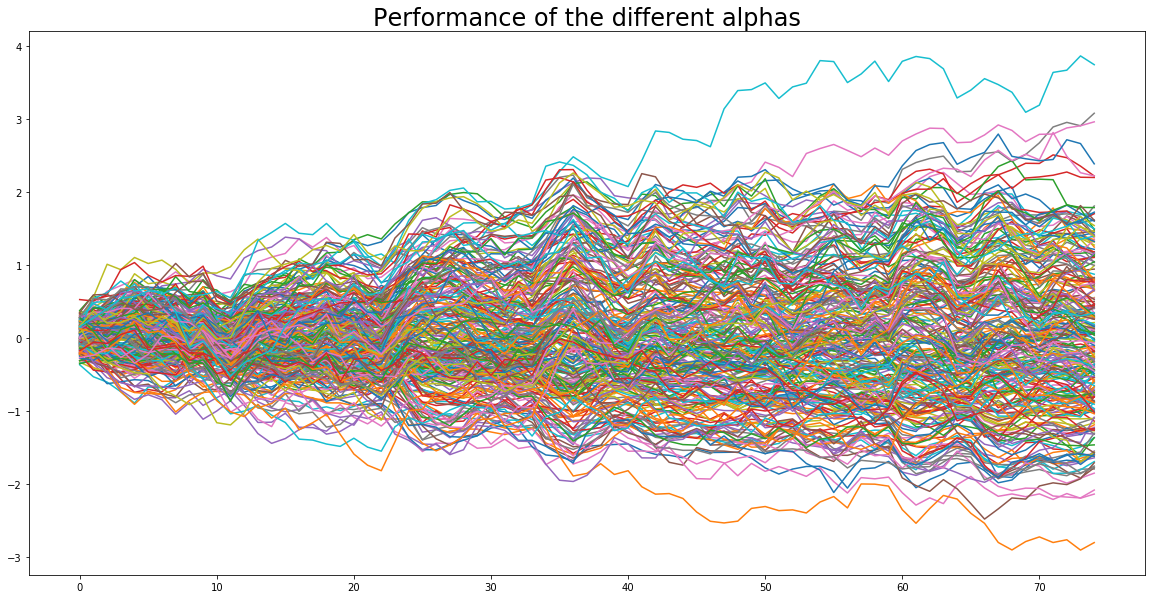

In [4]:
alphas_returns = np.random.multivariate_normal(
    mean_returns, cov=covar, size=nb_observations)

alphas_returns = pd.DataFrame(alphas_returns)
plt.figure(figsize=(20, 10))
plt.plot(alphas_returns.cumsum())
plt.title('Performance of the different alphas', fontsize=24)
plt.show()

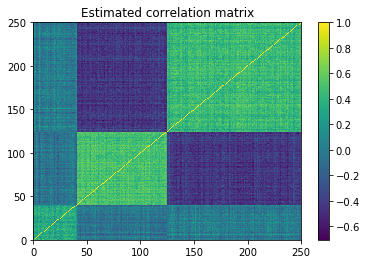

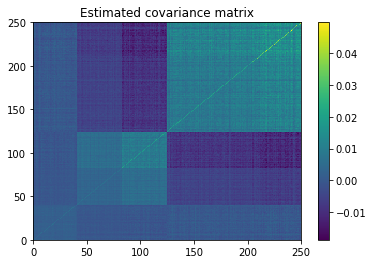

In [5]:
estimate_correl = alphas_returns.corr(method='pearson')
estimate_covar = alphas_returns.cov()
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix')
plt.show()

plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix')
plt.show()

In [6]:
distances = np.sqrt((1 - estimate_correl) / 2)

In [7]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

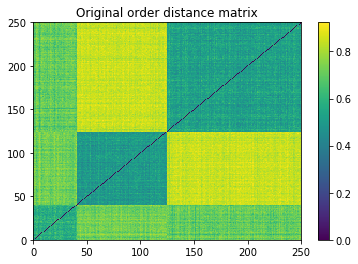

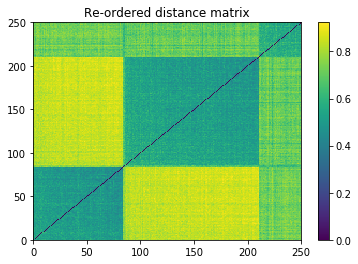

In [8]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')
plt.pcolormesh(distances)
plt.colorbar()
plt.title('Original order distance matrix')
plt.show()

plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

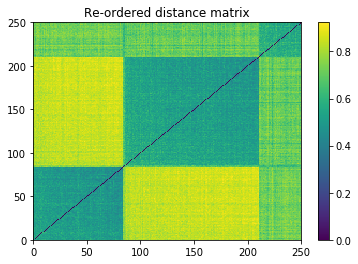

In [9]:
HRP = HierarchicalRiskParity()

HRP.stageOne(dist_mat = distances.to_numpy(), method = 'single')
dist_mat, order = HRP.stageTwo(dist_mat = distances.to_numpy())
             
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

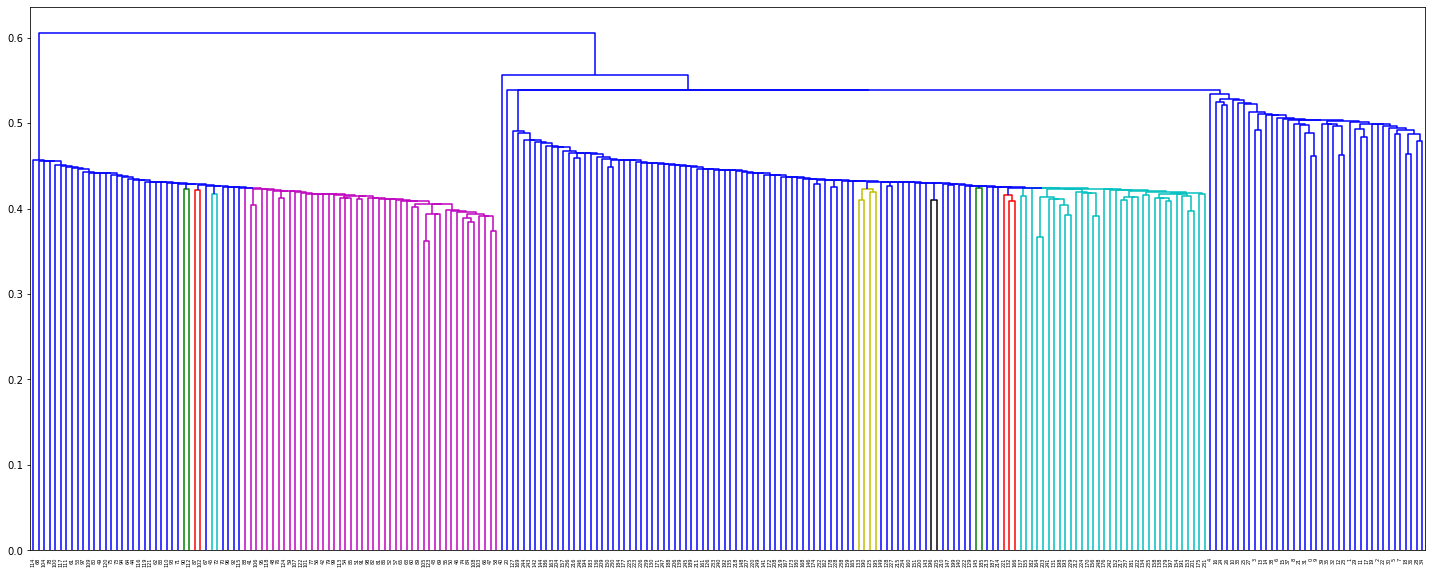

In [10]:
HRP.plotLink()

In [12]:
print(order)

[114, 68, 104, 78, 100, 117, 111, 61, 53, 97, 109, 80, 49, 120, 75, 73, 94, 64, 44, 116, 119, 121, 62, 83, 110, 93, 71, 90, 112, 87, 102, 67, 45, 72, 70, 96, 92, 115, 88, 41, 106, 95, 118, 48, 76, 124, 59, 107, 122, 101, 77, 56, 42, 79, 99, 113, 54, 85, 51, 91, 98, 82, 81, 86, 52, 57, 65, 63, 60, 89, 105, 123, 43, 69, 55, 50, 46, 74, 84, 108, 103, 66, 47, 58, 40, 20, 127, 169, 244, 243, 142, 144, 186, 163, 204, 157, 236, 216, 246, 194, 183, 136, 209, 150, 230, 184, 177, 225, 223, 226, 239, 130, 171, 247, 188, 206, 139, 245, 189, 211, 161, 126, 233, 240, 192, 135, 218, 148, 207, 220, 249, 141, 172, 208, 219, 167, 173, 180, 168, 146, 174, 232, 162, 178, 228, 238, 159, 165, 133, 190, 125, 195, 149, 128, 227, 215, 234, 160, 151, 200, 143, 196, 205, 210, 147, 199, 140, 222, 129, 145, 185, 213, 187, 214, 221, 132, 166, 137, 155, 182, 164, 203, 241, 131, 198, 193, 229, 212, 224, 170, 156, 248, 176, 242, 152, 217, 237, 181, 202, 134, 235, 158, 138, 179, 197, 154, 191, 153, 201, 175, 231, 4, 16

In [11]:
clustered_alphas = [order]

print(clustered_alphas)

for cluster in clustered_alphas:
    for start, end in ((0, len(cluster) // 2), (len(cluster) // 2, len(cluster))):
        print(start)
        print('\n')
            # print(end)

[[114, 68, 104, 78, 100, 117, 111, 61, 53, 97, 109, 80, 49, 120, 75, 73, 94, 64, 44, 116, 119, 121, 62, 83, 110, 93, 71, 90, 112, 87, 102, 67, 45, 72, 70, 96, 92, 115, 88, 41, 106, 95, 118, 48, 76, 124, 59, 107, 122, 101, 77, 56, 42, 79, 99, 113, 54, 85, 51, 91, 98, 82, 81, 86, 52, 57, 65, 63, 60, 89, 105, 123, 43, 69, 55, 50, 46, 74, 84, 108, 103, 66, 47, 58, 40, 20, 127, 169, 244, 243, 142, 144, 186, 163, 204, 157, 236, 216, 246, 194, 183, 136, 209, 150, 230, 184, 177, 225, 223, 226, 239, 130, 171, 247, 188, 206, 139, 245, 189, 211, 161, 126, 233, 240, 192, 135, 218, 148, 207, 220, 249, 141, 172, 208, 219, 167, 173, 180, 168, 146, 174, 232, 162, 178, 228, 238, 159, 165, 133, 190, 125, 195, 149, 128, 227, 215, 234, 160, 151, 200, 143, 196, 205, 210, 147, 199, 140, 222, 129, 145, 185, 213, 187, 214, 221, 132, 166, 137, 155, 182, 164, 203, 241, 131, 198, 193, 229, 212, 224, 170, 156, 248, 176, 242, 152, 217, 237, 181, 202, 134, 235, 158, 138, 179, 197, 154, 191, 153, 201, 175, 231, 4, 1